In [1]:
# === CONFIGURATION ===
SAVE_INTERMEDIATE_FILES = False  # Set to True to save intermediate CSVs
SAVE_FINAL_FILE = True  # Set to True to save final cleaned CSV
INTERMEDIATE_FILE_PATH = '../data/cleaned_train.csv'
FINAL_FILE_PATH = '../data/cleaned_train_with_amenities.csv'

In [2]:
from math import fabs

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import BallTree

In [3]:


# 1. Define the Coordinate Systems (CRSs)
# EPSG:4326 is the standard WGS84 for Lat/Long (used by GPS, Google Maps)
# EPSG:3414 is the SVY21 / Singapore TM (Easting/Northing in meters)
WGS84 = "EPSG:4326"
SVY21 = "EPSG:3414"

# Create a Transformer object to handle the conversion from WGS84 to SVY21
transformer = pyproj.Transformer.from_crs(WGS84, SVY21, always_xy=True)

def calculate_manhattan_distance_svy21(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculates the Manhattan (L1) distance between two WGS84 points
    by first projecting them into the planar SVY21 coordinate system (meters).

    Args:
        lat1, lon1: Latitude and Longitude of Point 1.
        lat2, lon2: Latitude and Longitude of Point 2.

    Returns:
        The Manhattan distance in meters.
    """
    
    # 2. Convert WGS84 (Lat/Lon) to SVY21 (Easting/Northing)
    # pyproj's 'always_xy=True' means it expects (Longitude, Latitude) order for WGS84
    # and returns (Easting, Northing) for SVY21.
    
    # Point 1: Property Location
    E1, N1 = transformer.transform(lon1, lat1)
    
    # Point 2: MRT Station Location
    E2, N2 = transformer.transform(lon2, lat2)
    
    # 3. Calculate Manhattan Distance (L1 Norm)
    # d = |E2 - E1| + |N2 - N1|
    delta_E = fabs(E2 - E1) # Absolute difference in Easting (X-axis)
    delta_N = fabs(N2 - N1) # Absolute difference in Northing (Y-axis)
    
    manhattan_dist_m = delta_E + delta_N
    
    return manhattan_dist_m

In [4]:
train_df = pd.read_csv('../data/train.csv')
# for consistency, change text of interest to lowercase in train_df
# change all column names to lowercase
train_df.columns = [col.lower() for col in train_df.columns]
# change train_df column 'town' to lowercase
train_df['town'] = train_df['town'].str.lower()
# change train_df column 'block' to lowercase
train_df['block'] = train_df['block'].str.lower()
# change train_df column 'street' to lowercase
train_df['street'] = train_df['street'].str.lower()
# drop 'eco_category' column from train_df
train_df = train_df.drop(columns=['eco_category'])

In [5]:
hdb_df = pd.read_csv('../data/sg-hdb-block-details.csv')
# for consistency, change text of interest to lowercase in hdb_df
# change all column names to lowercase
hdb_df.columns = [col.lower() for col in hdb_df.columns]
# change hdb_df column name 'address' to 'street' for consistency with train_df
hdb_df = hdb_df.rename(columns={'address': 'street'})
# change hdb_df column 'town' to lowercase
hdb_df['town'] = hdb_df['town'].str.lower()
# change hdb_df column 'block' to lowercase
hdb_df['block'] = hdb_df['block'].str.lower()
# change hdb_df column 'street' to lowercase
hdb_df['street'] = hdb_df['street'].str.lower()
# change hdb_df column 'postal_code' to string and pad with leading zeros to ensure 6 digits
hdb_df['postal_code'] = hdb_df['postal_code'].astype(str).str.zfill(6)
# change hdb_df column 'region' to lowercase
hdb_df['region'] = hdb_df['region'].str.lower()
#match hdb_df.town with train_df.town, hdb_df.block with train_df.block, hdb_df.street with train_df.street to get hdb_df.postal_code, hdb_df.latitude, hdb_df.longitude, hdb_df.max_floor, hdb_df.region into train_df
train_df = pd.merge(train_df, hdb_df[['town', 'block', 'street', 'postal_code', 'latitude', 'longitude', 'max_floor', 'subzone']], left_on=['town', 'block', 'street'], right_on=['town', 'block', 'street'], how='left')

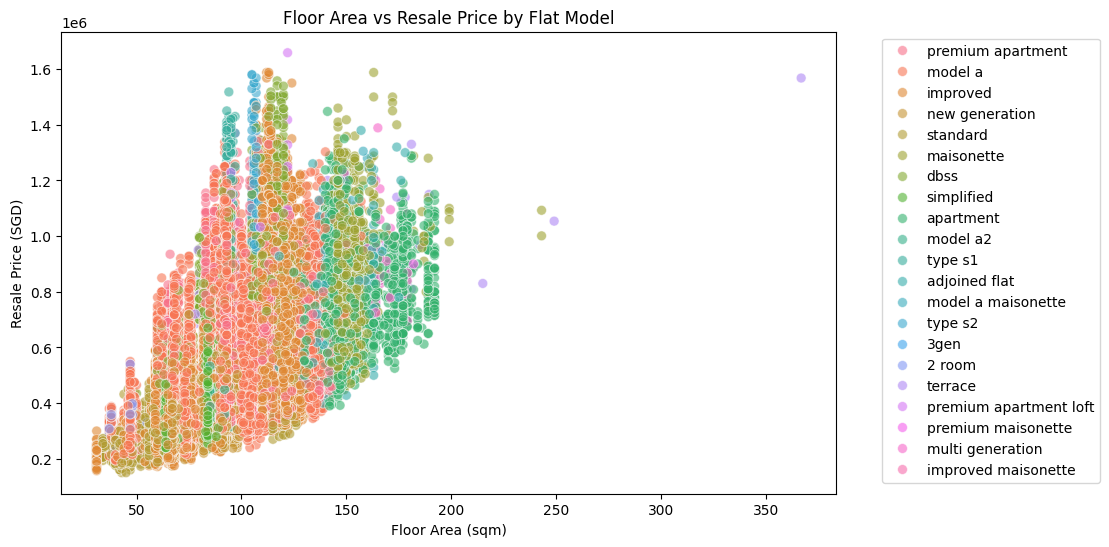

In [6]:
# Scatter plot of floor area vs resale price, colored by flat model
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=train_df,
    x='floor_area_sqm',
    y='resale_price',
    hue='flat_model',
    alpha=0.6,
    s=50
)
plt.title('Floor Area vs Resale Price by Flat Model')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price (SGD)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [7]:
# mapping of floor_range to ordinal values
floor_range_mapping  = {
    '01 to 03': 2,
    '04 to 06': 7,
    '07 to 09': 8,
    '10 to 12': 11,
    '13 to 15': 14,
    '16 to 18': 17,
    '19 to 21': 20,
    '22 to 24': 23,
    '25 to 27': 26,
    '28 to 30': 29,
    '31 to 33': 32,
    '34 to 36': 35,
    '37 to 39': 38,
    '40 to 42': 41,
    '43 to 45': 44,
    '46 to 48': 47,
    '49 to 51': 50
}
# list count of floor_range values
floor_range_counts = train_df['floor_range'].value_counts().sort_index()
print(floor_range_counts)
# insert new column height = ordinal value of floor_range
train_df['height'] = train_df['floor_range'].map(floor_range_mapping)
# drop original floor_range column
train_df = train_df.drop(columns=['floor_range'])

floor_range
01 to 03    28682
04 to 06    37358
07 to 09    34103
10 to 12    30239
13 to 15    15812
16 to 18     7342
19 to 21     3147
22 to 24     2212
25 to 27     1392
28 to 30      887
31 to 33      473
34 to 36      426
37 to 39      359
40 to 42      158
43 to 45       52
46 to 48       35
49 to 51       14
Name: count, dtype: int64


In [8]:
month_dt = pd.to_datetime(train_df['month'])
train_df['month_from2017'] = (month_dt.dt.year - 2017) * 12 + month_dt.dt.month
LEASE_startyr = (train_df['lease_commence_data']-2017)*12
train_df['age_at_sale'] = train_df['month_from2017'] - LEASE_startyr


In [9]:
# load hdb resale price index data
hdb_rpi_df = pd.read_csv('../data/sg-hdb-rpi.csv')
hdb_rpi_df.columns = [col.lower() for col in hdb_rpi_df.columns]
hdb_rpi_df['year'] = hdb_rpi_df['year'].astype(int)
hdb_rpi_df['q'] = hdb_rpi_df['q'].astype(int)

In [10]:
# create columns 'year' and 'quarter' in train_df from first 4 digits and last 2 digits of 'month'
train_df['year'] = pd.to_datetime(train_df['month'], format='%Y-%m').dt.year
train_df['quarter'] = pd.to_datetime(train_df['month'], format='%Y-%m').dt.quarter
# map train_df.month to HDB resale price index for that quarter
train_df = pd.merge(train_df, hdb_rpi_df, left_on=['year', 'quarter'], right_on=['year', 'q'], how='left')
# get latest resale price index to set as default value
latest_rpi = hdb_rpi_df.loc[hdb_rpi_df['year'] == hdb_rpi_df['year'].max()]
latest_rpi = latest_rpi.loc[latest_rpi['q'] == latest_rpi['q'].max()]
default_rpi = latest_rpi['index'].values[0]
# fill any missing values in index column with latest resale price index
train_df['index'] = train_df['index'].fillna(default_rpi)
if SAVE_INTERMEDIATE_FILES:
    # save cleaned train_df to csv
    train_df.to_csv(INTERMEDIATE_FILE_PATH, index=False)
# drop columns 'month', 'year', 'quarter', 'q' from train_df
train_df = train_df.drop(columns=['month', 'year', 'q', 'quarter_x', 'quarter_y'])

In [11]:
# add nearest mrt station and distance to postal code table
# load sg-mrt-stations.csv
mrt_df = pd.read_csv('../data/sg-mrt-stations.csv')
mrt_df.columns = [col.lower() for col in mrt_df.columns]
# change all name to lowercase
mrt_df['name'] = mrt_df['name'].str.lower()
# remove duplicate names in mrt_df, keep first occurrence
mrt_df = mrt_df.drop_duplicates(subset=['name']).reset_index(drop=True)

def find_nearest_mrt(row):
    min_distance = float('inf')
    nearest_station = None
    for _, mrt_row in mrt_df.iterrows():
        distance = calculate_manhattan_distance_svy21(row['latitude'], row['longitude'], mrt_row['latitude'], mrt_row['longitude'])
        if distance < min_distance:
            min_distance = distance
            nearest_station, station_status = mrt_row['name'], mrt_row['status']
    return pd.Series([nearest_station, min_distance, station_status])

# create postal code table based on all postal codes in train_df
postal_codes_df = train_df[['postal_code', 'longitude', 'latitude', 'subzone']].drop_duplicates().reset_index(drop=True)
# add nearest mrt to postal_codes_df
postal_codes_df[['nearest_mrt', 'mrt_distance', 'mrt_status']] = postal_codes_df.apply(find_nearest_mrt, axis=1)

In [12]:
# add nearest shopping mall and distance to postal code table
# load sg-shopping-malls.csv
mall_df = pd.read_csv('../data/sg-shopping-malls.csv')
mall_df.columns = [col.lower() for col in mall_df.columns]
# change all name to lowercase
mall_df['name'] = mall_df['name'].str.lower()
# remove duplicate names in mall_df, keep first occurrence
mall_df = mall_df.drop_duplicates(subset=['name']).reset_index(drop=True)

def find_nearest_mall(row):
    min_distance = float('inf')
    nearest_mall = None
    for _, mall_row in mall_df.iterrows():
        distance = calculate_manhattan_distance_svy21(row['latitude'], row['longitude'], mall_row['latitude'], mall_row['longitude'])
        if distance < min_distance:
            min_distance = distance
            nearest_mall = mall_row['name']
    return pd.Series([nearest_mall, min_distance])

# add nearest mall to postal_codes_df
postal_codes_df[['nearest_mall', 'mall_distance']] = postal_codes_df.apply(find_nearest_mall, axis=1)


In [13]:
# add nearest gov hawker centre and distance to postal code table
# load sg-gov-hawkers.csv
hawker_df = pd.read_csv('../data/sg-gov-hawkers.csv')
hawker_df.columns = [col.lower() for col in hawker_df.columns]
# change all name to lowercase
hawker_df['name'] = hawker_df['name'].str.lower()
# remove duplicate names in hawker_df, keep first occurrence
hawker_df = hawker_df.drop_duplicates(subset=['name']).reset_index(drop=True)
def find_nearest_hawker(row):
    min_distance = float('inf')
    nearest_hawker = None
    for _, hawker_row in hawker_df.iterrows():
        distance = calculate_manhattan_distance_svy21(row['latitude'], row['longitude'], hawker_row['latitude'], hawker_row['longitude'])
        if distance < min_distance:
            min_distance = distance
            nearest_hawker = hawker_row['name']
    return pd.Series([nearest_hawker, min_distance])
# add nearest hawker to postal_codes_df
postal_codes_df[['nearest_hawker', 'hawker_distance']] = postal_codes_df.apply(find_nearest_hawker, axis=1)

In [14]:
# add nearest primary school and distance to postal code table
# load sg-primary-schools.csv
primary_school_df = pd.read_csv('../data/sg-primary-schools.csv')
primary_school_df.columns = [col.lower() for col in primary_school_df.columns]
# change all name to lowercase
primary_school_df['name'] = primary_school_df['name'].str.lower()
# remove duplicate names in primary_school_df, keep first occurrence
primary_school_df = primary_school_df.drop_duplicates(subset=['name']).reset_index(drop=True)

def find_nearest_primary_school(row):
    min_distance = float('inf')
    nearest_primary_school = None
    for _, primary_school_row in primary_school_df.iterrows():
        distance = calculate_manhattan_distance_svy21(row['latitude'], row['longitude'], primary_school_row['latitude'], primary_school_row['longitude'])
        if distance < min_distance:
            min_distance = distance
            nearest_primary_school = primary_school_row['name']
    return pd.Series([nearest_primary_school, min_distance])

# add nearest primary school to postal_codes_df
postal_codes_df[['nearest_primary_school', 'primary_school_distance']] = postal_codes_df.apply(find_nearest_primary_school, axis=1)


In [15]:
# add nearest secondary school and distance to postal code table
# load sg-secondary-schools.csv
secondary_school_df = pd.read_csv('../data/sg-secondary-schools.csv')
secondary_school_df.columns = [col.lower() for col in secondary_school_df.columns]
# change all name to lowercase
secondary_school_df['name'] = secondary_school_df['name'].str.lower()
# remove duplicate names in secondary_school_df, keep first occurrence
secondary_school_df = secondary_school_df.drop_duplicates(subset=['name']).reset_index(drop=True)

def find_nearest_secondary_school(row):
    min_distance = float('inf')
    nearest_secondary_school = None
    for _, secondary_school_row in secondary_school_df.iterrows():
        distance = calculate_manhattan_distance_svy21(row['latitude'], row['longitude'], secondary_school_row['latitude'], secondary_school_row['longitude'])
        if distance < min_distance:
            min_distance = distance
            nearest_secondary_school = secondary_school_row['name']
    return pd.Series([nearest_secondary_school, min_distance])

# add nearest secondary school to postal_codes_df
postal_codes_df[['nearest_secondary_school', 'secondary_school_distance']] = postal_codes_df.apply(find_nearest_secondary_school, axis=1)


In [16]:
print(postal_codes_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9631 entries, 0 to 9630
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   postal_code                9631 non-null   object 
 1   longitude                  9631 non-null   float64
 2   latitude                   9631 non-null   float64
 3   subzone                    9631 non-null   object 
 4   nearest_mrt                9631 non-null   object 
 5   mrt_distance               9631 non-null   float64
 6   mrt_status                 9631 non-null   object 
 7   nearest_mall               9631 non-null   object 
 8   mall_distance              9631 non-null   float64
 9   nearest_hawker             9631 non-null   object 
 10  hawker_distance            9631 non-null   float64
 11  nearest_primary_school     9631 non-null   object 
 12  primary_school_distance    9631 non-null   float64
 13  nearest_secondary_school   9631 non-null   objec

In [17]:
# add nearest mrt, mrt distance, mrt status, nearest primary school, primary school distance, nearest secondary school, secondary school distance, nearest mall, nearest mall distance, nearest hawker, nearest hawker distance to train_df
train_df = pd.merge(train_df, postal_codes_df[['postal_code', 'nearest_mrt', 'mrt_distance', 'mrt_status', 'nearest_primary_school', 'primary_school_distance', 'nearest_secondary_school', 'secondary_school_distance', 'nearest_mall', 'mall_distance', 'nearest_hawker', 'hawker_distance']], on='postal_code', how='left')


In [18]:
# Clean up subzone names by removing whitespace
train_df['subzone'] = train_df['subzone'].str.strip()
print(train_df['subzone'].unique())

# Create resale_price_per_sqm feature
train_df['resale_price_per_sqm'] = train_df['resale_price'] / train_df['floor_area_sqm']

# Remove hyphens in flat types for consistency and lower capitalization
train_df['flat_type'] = train_df['flat_type'].str.replace('-', ' ')
train_df['flat_type'] = train_df['flat_type'].str.lower()

['woodlands east' 'marymount' 'saujana' 'punggol field' 'trafalgar'
 'clementi north' 'fajar' 'bedok north' 'yishun south' 'fernvale' 'dover'
 'waterway east' 'bukit batok central' 'woodlands south'
 'sengkang town centre' 'pasir ris drive' 'toa payoh central'
 'kampong ubi' 'punggol town centre' 'matilda' 'yishun east' 'ghim moh'
 'potong pasir' 'boon teck' 'tampines west' 'telok blangah drive'
 'hong kah north' 'chong boon' 'sembawang east' 'tiong bahru station'
 'kebun bahru' 'keat hong' 'jurong west central' 'clementi central'
 'north coast' 'braddell' 'tampines east' 'woodlands west' 'rivervale'
 'anchorvale' 'balestier' 'hong kah' 'simei' 'geylang bahru' 'midview'
 'sembawang central' 'macpherson' 'lorong ah soo' 'pasir ris central'
 'cheng san' 'mei chin' 'bendemeer' 'choa chu kang north'
 'choa chu kang central' 'boon lay place' 'margaret drive' 'woodgrove'
 'tiong bahru' 'tampines north' 'bukit batok south' 'upper paya lebar'
 'senja' 'teck whye' 'peng siang' 'yishun west' 'bi

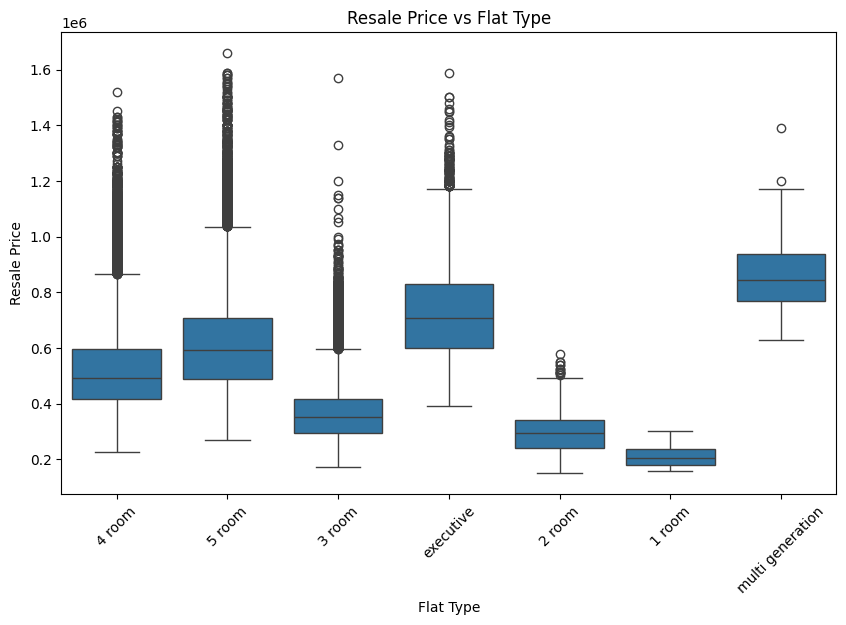

flat_type
1 room              208739.578947
2 room              294752.512957
3 room              367421.169600
4 room              521896.382574
5 room              616811.113494
executive           723978.701265
multi generation    861066.941176
Name: resale_price, dtype: float64


In [19]:
# Plot resale price vs flat type
plt.figure(figsize=(10, 6))
sns.boxplot(x='flat_type', y='resale_price', data=train_df)
plt.title('Resale Price vs Flat Type')
plt.xlabel('Flat Type')
plt.ylabel('Resale Price')
plt.xticks(rotation=45)
plt.show()

# print mean of resale prices for each flat type
flat_type_means = train_df.groupby('flat_type')['resale_price'].mean().sort_values()
print(flat_type_means)

In [20]:
# Based on boxplot, we will assign numerical values to flat types
flat_type_mapping = {
    '1 room': 1,
    '2 room': 2,
    '3 room': 3,
    '4 room': 4,
    '5 room': 5,
    'executive': 6,
    'multi generation': 7
}
train_df['flat_type_num'] = train_df['flat_type'].map(flat_type_mapping)

In [21]:
# print mean of resale prices for each flat model
flat_model_means = train_df.groupby('flat_model')['resale_price'].mean().sort_values()
for model, mean_price in flat_model_means.items():
    print(f"{model}: {mean_price:.2f}")

2 room: 349346.42
new generation: 379885.56
simplified: 400799.18
model a2: 414352.15
standard: 440994.90
model a: 510538.22
improved: 528159.89
premium apartment: 559151.36
apartment: 708902.73
3gen: 727848.20
improved maisonette: 759984.00
adjoined flat: 766747.53
maisonette: 769759.90
model a maisonette: 786991.23
dbss: 788315.92
premium maisonette: 795153.85
multi generation: 861066.94
terrace: 874700.61
premium apartment loft: 997330.40
type s1: 1050474.03
type s2: 1152880.55


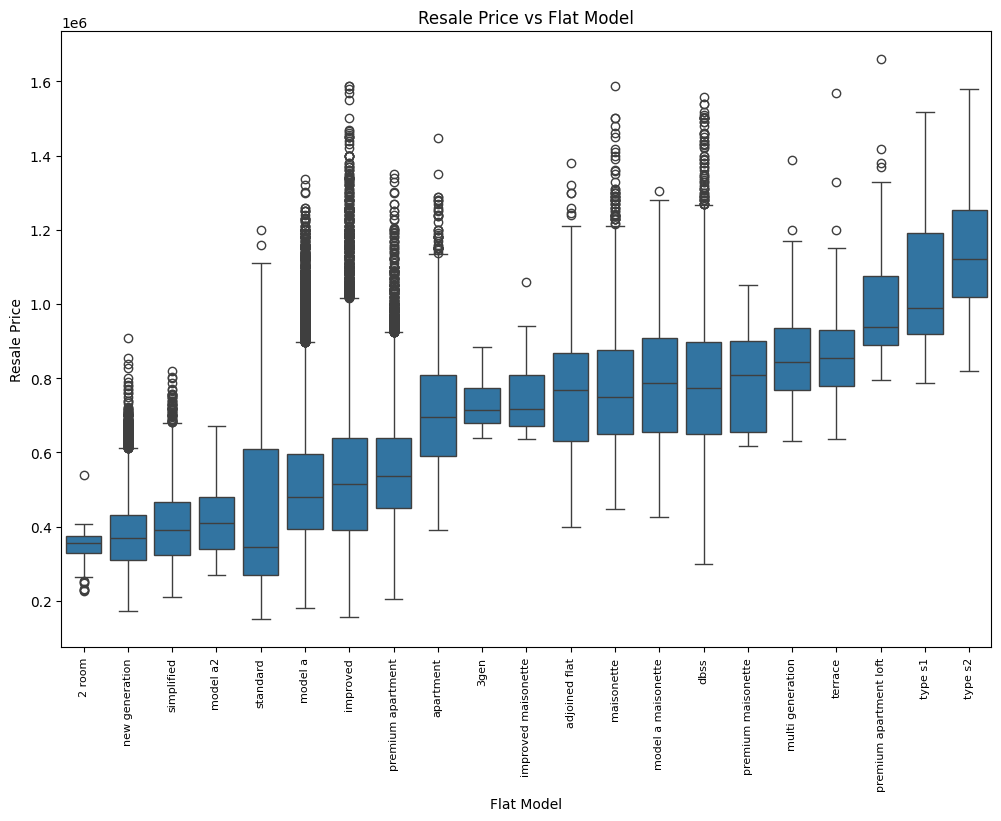

In [22]:
# Plot resale price vs flat model by boxplot, in ascending order of mean resale price
plt.figure(figsize=(12, 8))
order = flat_model_means.index.tolist()
sns.boxplot(x='flat_model', y='resale_price', data=train_df, order=order)
plt.title('Resale Price vs Flat Model')
plt.xlabel('Flat Model')
plt.ylabel('Resale Price')
plt.xticks(rotation=90, fontsize=8)
plt.show()



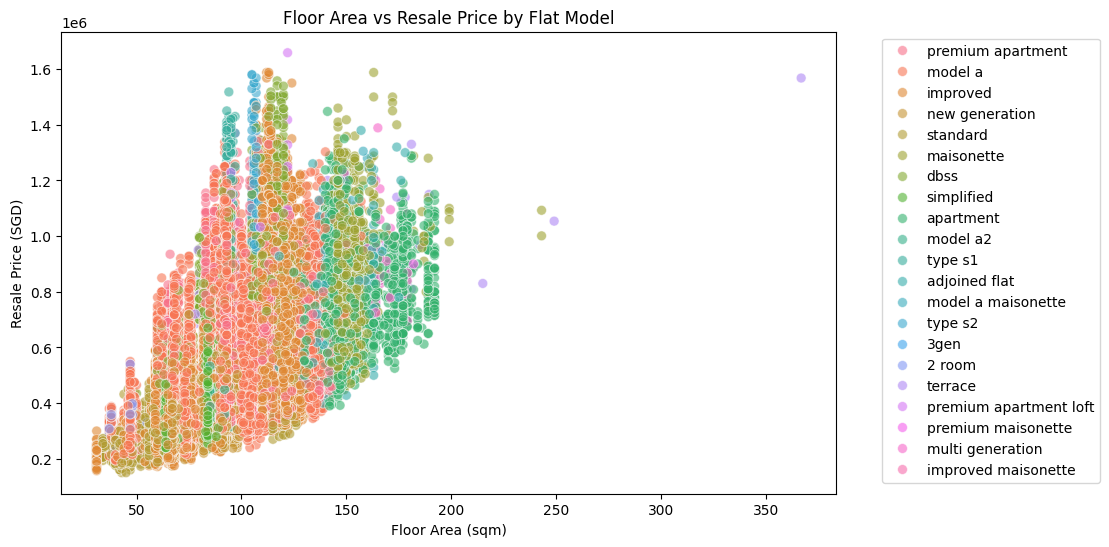

In [23]:
# Scatter plot of floor area vs resale price, colored by flat model
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=train_df,
    x='floor_area_sqm',
    y='resale_price',
    hue='flat_model',
    alpha=0.6,
    s=50
)
plt.title('Floor Area vs Resale Price by Flat Model')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price (SGD)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [24]:
# Based on boxplot, we will assign numerical values to flat models
flat_model_mapping = {
    '2 room': 1,
    'new generation': 2,
    'simplified': 3,
    'model a2': 4,
    'standard': 5,
    'model a': 6,
    'improved': 7,
    'premium apartment': 8,
    'apartment': 9,
    '3gen': 10,
    'improved maisonette': 11,
    'adjoined flat': 12,
    'maisonette': 13,
    'model a maisonette': 14,
    'dbss': 15,
    'premium maisonette': 16,
    'multi generation': 17,
    'terrace': 18,
    'premium apartment loft': 19,
    'type s1': 20,
    'type s2': 21
}
train_df['flat_model_num'] = train_df['flat_model'].map(flat_model_mapping)

In [25]:
# change mrt_status to binary feature: 1 if 'open', 0 otherwise
train_df['mrt_status'] = train_df['mrt_status'].apply(lambda x: 1 if x == 'open' else 0)

# Modify distance features
distance_features = ['mrt_distance', 'mall_distance', 'primary_school_distance', 'secondary_school_distance', 'hawker_distance']
# change distance_features to inverse distance to give higher weight to nearer amenities
for feature in distance_features:
    train_df[feature] = 1/(train_df[feature] + 1) # add 1 to avoid division by zero

In [26]:
# Count number of amenities within 5km distance

hdb_coordinates = np.radians(train_df[["latitude", "longitude"]].to_numpy())
walking_distance = 5/6371

hawker_coordinates = np.radians(hawker_df[["latitude", "longitude"]].to_numpy())
hawker_tree = BallTree(hawker_coordinates, metric="haversine")
near_hawker_idx = hawker_tree.query_radius(hdb_coordinates, r=walking_distance, return_distance=False)
near_hawker_count = np.array([len(idx) for idx in near_hawker_idx])
train_df["near_hawker_count"] = near_hawker_count

mrt_coordinates = np.radians(mrt_df[["latitude", "longitude"]].to_numpy())
mrt_tree = BallTree(mrt_coordinates, metric="haversine")
near_mrt_idx = mrt_tree.query_radius(hdb_coordinates, r=walking_distance, return_distance=False)
near_mrt_count = np.array([len(idx) for idx in near_mrt_idx])
train_df["near_mrt_count"] = near_mrt_count

primary_school_coordinates = np.radians(primary_school_df[["latitude", "longitude"]].to_numpy())
primary_school_tree = BallTree(primary_school_coordinates, metric="haversine")
near_primary_school_idx = primary_school_tree.query_radius(hdb_coordinates, r=walking_distance, return_distance=False)
near_primary_school_count = np.array([len(idx) for idx in near_primary_school_idx])
train_df["near_primary_school_count"] = near_primary_school_count

secondary_school_coordinates = np.radians(secondary_school_df[["latitude", "longitude"]].to_numpy())
secondary_school_tree = BallTree(secondary_school_coordinates, metric="haversine")
near_secondary_school_idx = secondary_school_tree.query_radius(hdb_coordinates, r=walking_distance, return_distance=False)
near_secondary_school_count = np.array([len(idx) for idx in near_secondary_school_idx])
train_df["near_secondary_school_count"] = near_secondary_school_count

mall_coordinates = np.radians(mall_df[["latitude", "longitude"]].to_numpy())
mall_tree = BallTree(mall_coordinates, metric="haversine")
near_mall_idx = mall_tree.query_radius(hdb_coordinates, r=walking_distance, return_distance=False)
near_mall_count = np.array([len(idx) for idx in near_mall_idx])
train_df["near_mall_count"] = near_mall_count

In [27]:
print(train_df.columns)

Index(['town', 'flat_type', 'block', 'street', 'floor_area_sqm', 'flat_model',
       'lease_commence_data', 'resale_price', 'postal_code', 'latitude',
       'longitude', 'max_floor', 'subzone', 'height', 'month_from2017',
       'age_at_sale', 'index', 'nearest_mrt', 'mrt_distance', 'mrt_status',
       'nearest_primary_school', 'primary_school_distance',
       'nearest_secondary_school', 'secondary_school_distance', 'nearest_mall',
       'mall_distance', 'nearest_hawker', 'hawker_distance',
       'resale_price_per_sqm', 'flat_type_num', 'flat_model_num',
       'near_hawker_count', 'near_mrt_count', 'near_primary_school_count',
       'near_secondary_school_count', 'near_mall_count'],
      dtype='object')


In [28]:
# check no na or missing values after preprocessing
print(train_df.isna().sum())

town                           0
flat_type                      0
block                          0
street                         0
floor_area_sqm                 0
flat_model                     0
lease_commence_data            0
resale_price                   0
postal_code                    0
latitude                       0
longitude                      0
max_floor                      0
subzone                        0
height                         0
month_from2017                 0
age_at_sale                    0
index                          0
nearest_mrt                    0
mrt_distance                   0
mrt_status                     0
nearest_primary_school         0
primary_school_distance        0
nearest_secondary_school       0
secondary_school_distance      0
nearest_mall                   0
mall_distance                  0
nearest_hawker                 0
hawker_distance                0
resale_price_per_sqm           0
flat_type_num                  0
flat_model

In [29]:
print(train_df.info())
if SAVE_FINAL_FILE:   
    # save cleaned train_df to csv
    train_df.to_csv(FINAL_FILE_PATH, index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162691 entries, 0 to 162690
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   town                         162691 non-null  object 
 1   flat_type                    162691 non-null  object 
 2   block                        162691 non-null  object 
 3   street                       162691 non-null  object 
 4   floor_area_sqm               162691 non-null  float64
 5   flat_model                   162691 non-null  object 
 6   lease_commence_data          162691 non-null  int64  
 7   resale_price                 162691 non-null  float64
 8   postal_code                  162691 non-null  object 
 9   latitude                     162691 non-null  float64
 10  longitude                    162691 non-null  float64
 11  max_floor                    162691 non-null  int64  
 12  subzone                      162691 non-null  object 
 13 

In [30]:
train_df.columns

Index(['town', 'flat_type', 'block', 'street', 'floor_area_sqm', 'flat_model',
       'lease_commence_data', 'resale_price', 'postal_code', 'latitude',
       'longitude', 'max_floor', 'subzone', 'height', 'month_from2017',
       'age_at_sale', 'index', 'nearest_mrt', 'mrt_distance', 'mrt_status',
       'nearest_primary_school', 'primary_school_distance',
       'nearest_secondary_school', 'secondary_school_distance', 'nearest_mall',
       'mall_distance', 'nearest_hawker', 'hawker_distance',
       'resale_price_per_sqm', 'flat_type_num', 'flat_model_num',
       'near_hawker_count', 'near_mrt_count', 'near_primary_school_count',
       'near_secondary_school_count', 'near_mall_count'],
      dtype='object')